# **Assignment 3 Anomaly Detection**

Unsupervised anomaly detection
Training a model to determine whether the given image is similar with the training data.

## Package installation

In [1]:
## # Training progress bar
!pip install -q qqdm

## Import packages

In [2]:
import paddle
import paddle.nn as nn
from paddle.io import Dataset, DataLoader
import paddle.vision.transforms as transforms
from paddle.optimizer import Adam, AdamW
import paddle.nn.functional as F
import paddle.fluid as fluid
import numpy as np
import random

from qqdm import qqdm, format_str
import pandas as pd
# FOr eval
from sklearn.metrics import roc_auc_score
# For plotting
import matplotlib.pyplot as plt

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matp

## Preparing Data

In [3]:
#!unzip -o data/data173899/pr_2023_fall_a3.zip -d work/
#!ls work/

Conclude:
* trainingset.npy: training data, 90000 human faces
* testingset.npy: testing data
    * About 5000 from the same distribution with training data (label 0)
    * About 5000 from another distribution (anomalies, label 1)
* privatetestingset.npy: private testing data
* test_y.npy 
    * nomal label: 0。anomal label: 1.

Shape: (#images, 64, 64, 3) for each .npy file

In [4]:
import numpy as np

data_root='work/'

train = np.load(data_root + 'trainingset.npy', allow_pickle=True)
test = np.load(data_root + 'testingset.npy', allow_pickle=True)
test_y = np.load(data_root + 'test_y.npy', allow_pickle=True)

print(f'The shape of train dataset is {train.shape}. The shape of test dataset is {test.shape}.')

The shape of train dataset is (90000, 64, 64, 3). The shape of test dataset is (10000, 64, 64, 3).


## Model and loss

The auto encoder is a basic generation model. It uses the encoder-decoder architecture to encode first (such as compressing the image into a lower-dimensional vector), then decode (such as restoring the low-dimensional vector to an image), and restore the image.We use reconstruction loss to measure the model. The closer it is to the original image, the better, reconstruction error smaller. The common transformer model is this auto-encoder model.This work implements ' fcn_autoencoder', 'conv_autoencoder'and 'VAE'.
* fcn_autoencoder and vae are from https://github.com/L1aoXingyu/pytorch-beginner   
* conv_autoencoder is from https://github.com/jellycsc/PyTorch-CIFAR-10-autoencoder/   

In [5]:
class fcn_autoencoder(paddle.nn.Layer):
    def __init__(self):
        super(fcn_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64* 64 * 3, 128),  # 3072→128
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(), 
            nn.Linear(64, 12), 
            nn.ReLU(), 
            nn.Linear(12, 3)
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(), 
            nn.Linear(128, 64 * 64 * 3), 
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class conv_autoencoder(paddle.nn.Layer):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2D(3, 64, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2D(64),
            nn.Conv2D(64, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2D(64),
			nn.Conv2D(64, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2D(128),
        )
        self.decoder = nn.Sequential(
            nn.Conv2DTranspose(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2D(64),
			nn.Conv2DTranspose(64, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2D(64),
            nn.Conv2DTranspose(64, 3, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2D(3),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class VAE(paddle.nn.Layer):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2D(3, 12, 4, stride=2, padding=1),            
            nn.ReLU(),
            nn.Conv2D(12, 24, 4, stride=2, padding=1),    
            nn.ReLU(),
        )
        self.enc_out_1 = nn.Sequential(
            nn.Conv2D(24, 48, 4, stride=2, padding=1),  
            nn.ReLU(),
        )
        self.enc_out_2 = nn.Sequential(
            nn.Conv2D(24, 48, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
			nn.Conv2DTranspose(48, 24, 4, stride=2, padding=1), 
            nn.ReLU(),
		    nn.Conv2DTranspose(24, 12, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2DTranspose(12, 3, 4, stride=2, padding=1), 
            nn.Tanh(),
        )
    def encode(self, x):
        h1 = self.encoder(x)
        return self.enc_out_1(h1), self.enc_out_2(h1)

    def reparametrize(self, mu, logvar):
        # std = logvar.mul(0.5).exp_()  #文档错误
        std = logvar.multiply(paddle.to_tensor([0.5])).exp()
        # eps = paddle.to_tensor(std.shape()).normal_()  #错误
        eps = paddle.tensor.standard_normal(std.shape)
        # eps = Variable(eps)  #感觉没必要
        # return eps.mul(std).add_(mu)  #错误
        return eps.multiply(std).add(mu)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


def loss_vae(recon_x, x, mu, logvar, criterion):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    mse = criterion(recon_x, x)  # mse loss

    KLD_element = mu.pow(2).add(logvar.exp()).multiply(paddle.to_tensor([-1.0])).add(paddle.to_tensor([1.0])).add(logvar)
    KLD = paddle.sum(KLD_element).multiply(paddle.to_tensor([-0.5]))

    # KL divergence
    return mse + KLD

## Dataset module

Module for obtaining and processing data. The transform function here normalizes image's pixels from [0, 255] to [-1.0, 1.0].

In [6]:
class CustomTensorDataset(Dataset):
    def __init__(self, tensors):
        self.tensors = paddle.to_tensor(tensors,dtype="float32")
        if tensors.shape[-1] == 3:
            self.tensors = paddle.transpose(self.tensors, (0, 3, 1, 2))

        self.tensors = self.tensors * 2. / 255.  -1

    def __getitem__(self, index):
        x = self.tensors[index]
       
        return x, paddle.to_tensor([-1])

    def __len__(self):
        return len(self.tensors)

## Training

### Configuration

In [7]:
# Training hyperparameters
num_epochs = 20

batch_size = 2000
learning_rate = 1e-3

# Build training dataloader
train_dataset = CustomTensorDataset(train)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

# Model
model_type = 'vae' # selecting a model type from {'cnn', 'fcn', 'vae'}
model_classes = {'fcn':fcn_autoencoder(), 'cnn':conv_autoencoder(), 'vae':VAE()}
model = model_classes[model_type]


# Loss and optimizer
criterion = nn.MSELoss()
optimizer = Adam(parameters=model.parameters(), learning_rate=learning_rate)

W1107 17:14:00.453320   892 device_context.cc:362] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 10.1
W1107 17:14:00.457988   892 device_context.cc:372] device: 0, cuDNN Version: 7.6.


In [8]:
#开始训练
best_loss = np.inf
model.train()

qqdm_train = qqdm(range(num_epochs), desc=format_str('bold', 'Description'))
for epoch in qqdm_train:
    tot_loss = list()
    for data in train_dataloader():

        # ===================loading=====================
        img = data[0]
        if model_type in ['fcn']:
            img = paddle.reshape(img, [img.shape[0], -1])

        # ===================forward=====================        
        output = model(img)
        if model_type == 'vae':
            loss = loss_vae(output[0], img, output[1], output[2], criterion)
        else:
            loss = criterion(output, img)
        
        tot_loss.append(loss.numpy())
        # ===================backward====================
        optimizer.clear_grad()
        loss.backward()
        optimizer.step()
    # ===================save_best====================
    mean_loss = np.mean(tot_loss)
    if mean_loss < best_loss:
        best_loss = mean_loss
        paddle.save(model.state_dict(), 'best_model_{}.pdparams'.format(model_type))
    # ===================log========================
    qqdm_train.set_infos({
        'epoch': f'{epoch + 1:.0f}/{num_epochs:.0f}',
        'loss': f'{mean_loss:.4f}',
    })

 Iters    Elapsed Time      Speed                                               
 0/20           -             -                                                 
Description   0.0% |                                                           |/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:143: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py:89: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

## Evaluation
After inputting the testing image into the model, the reconstructed image can be obtained, and the squared difference between images can be obtained. 

In [9]:
# 开始预测
eval_batch_size = 200

# build testing dataloader
test_dataset = CustomTensorDataset(test)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
eval_loss = nn.MSELoss(reduction='none')

# load trained model
layer_state_dict = paddle.load('best_model_{}.pdparams'.format(model_type))
model.set_state_dict(layer_state_dict)
model.eval()

In [10]:
anomality = list()
for i, data in enumerate(test_dataloader()): 
    img = data[0]
    if model_type == 'fcn':
        img = paddle.reshape(img, [img.shape[0], -1])
    output = model(img)
    if model_type == 'vae':
        output = output[0]
    if model_type =='fcn':
        loss = eval_loss(output, img).sum(-1)
    else:
        loss = eval_loss(output, img).sum([1,2,3])
    anomality.append(loss.numpy())
anomality = np.concatenate(anomality, axis=0)
anomality = np.sqrt(anomality).reshape(len(test),1)

roc_score = roc_auc_score(test_y, anomality)
print("test roc_scoreacc is: {}".format(roc_score))
print("best loss is {}".format(best_loss))


test roc_scoreacc is: 0.5904659636186386
best loss is 0.5092727541923523


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


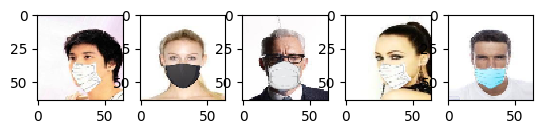

In [11]:
# 展示异常的图片
showlist = anomality.reshape(-1).argsort()[-5:].tolist()
for i,ind in enumerate(showlist):
    pic  = test[ind]
    plt.subplot(1,len(showlist),i+1)
    plt.imshow(pic)

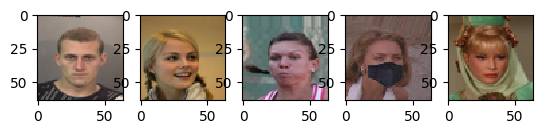

In [12]:
# 展示正常的图片
showlist = anomality.reshape(-1).argsort()[:5].tolist()
for i,ind in enumerate(showlist):
    pic  = test[ind]
    plt.subplot(1,len(showlist),i+1)
    plt.imshow(pic)

## Get Private Test Set Prediction

The 'prediction.csv' file should be submitted.

In [13]:
eval_batch_size = 200

# build testing dataloader
private_test = np.load(data_root + 'privatetestingset.npy', allow_pickle=True)
private_test_dataset = CustomTensorDataset(private_test)
private_test_dataloader = DataLoader(private_test_dataset, shuffle=False, batch_size=batch_size)
eval_loss = nn.MSELoss(reduction='none')

# load trained model
layer_state_dict = paddle.load('best_model_{}.pdparams'.format(model_type))
model.set_state_dict(layer_state_dict)
model.eval()

# prediction file 
out_file = 'a3.csv'

In [14]:
anomality = list()
for i, data in enumerate(private_test_dataloader()): 
    img = data[0]
    if model_type == 'fcn':
        img = paddle.reshape(img, [img.shape[0], -1])
    output = model(img)
    if model_type == 'vae':
        output = output[0]
    if model_type =='fcn':
        loss = eval_loss(output, img).sum(-1)
    else:
        loss = eval_loss(output, img).sum([1,2,3])
    anomality.append(loss.numpy())
anomality = np.concatenate(anomality, axis=0)
anomality = np.sqrt(anomality).reshape(len(test),1)

df = pd.DataFrame(anomality, columns=['score'])
df.to_csv(out_file, index_label = 'ID')


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:143: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py:89: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(slot[0], (np.ndarray, np.bool, numbers.Number)):
